# Flask App Metrics Analysis

This notebook analyzes the metrics data collected from the Flask application running in Kubernetes. We'll visualize how different metrics change over time:

- Number of instances (pod count)
- CPU Usage
- Requests per second
- Service time
- Workload (arrival rate of requests)

The visualization will help us understand how these metrics relate to each other and identify patterns in the system's behavior.

In [95]:
# Import libraries
import json
import pandas as pd
import matplotlib.pyplot as plt

# Set plot style
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

In [135]:
# def load_jmeter_data(csv_path, json_start_time):
#     """Load JMeter CSV data and calculate elapsed time based on JSON start time"""
#     try:
#         jmeter_df = pd.read_csv(csv_path)
        
#         # Convert timestamp to datetime
#         jmeter_df['timestamp_dt'] = pd.to_datetime(jmeter_df['timeStamp'], unit='ms')
        
#         # Calculate elapsed seconds from the JSON start time
#         json_start_dt = pd.to_datetime(json_start_time)
#         jmeter_df['elapsed_seconds'] = (jmeter_df['timestamp_dt'] - json_start_dt).dt.total_seconds()
        
#         # Convert elapsed time from ms to seconds
#         jmeter_df['response_time_seconds'] = jmeter_df['elapsed'] / 1000
        
#         # Sort by elapsed_seconds for proper rolling calculation
#         jmeter_df = jmeter_df.sort_values('elapsed_seconds')
        
#         return jmeter_df
        
#     except FileNotFoundError:
#         print(f"Warning: JMeter CSV file '{csv_path}' not found")
#         return None
#     except Exception as e:
#         print(f"Error loading JMeter data: {e}")
#         return None

def plot_metrics(file_path, jmeter_csv_path='jmeter.csv'):
    with open(file_path, 'r') as file:
        data = json.load(file)

    # Extract app name
    app_name = data['app_name']
    print(f"Analyzing data for: {app_name}")

    # Convert to DataFrame
    df = pd.DataFrame(data['history'])
    print(f"Loaded {len(df)} data points")

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Load JMeter data using the first timestamp from JSON as reference
    # jmeter_df = load_jmeter_data(jmeter_csv_path, df['timestamp'].iloc[0])

    # Use elapsed_seconds as index for plotting
    df_plot = df.copy()
    df_plot.set_index('elapsed_seconds', inplace=True)

    # Create a figure with subplots: main time series + histogram
    # fig = plt.figure(figsize=(16, 10))
    
    # Main time series plot (takes up most of the space)
    ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=3)
    # ax1.set_title('Response Time Distribution Over Time')
    
    # Response time distribution histogram (bottom left)
    # ax_hist = plt.subplot2grid((2, 3), (1, 0))
    
    # Statistics summary (bottom middle and right)
    # ax_stats = plt.subplot2grid((2, 3), (1, 1), colspan=2)

    # Color definitions for better visual distinction
    colors = {
        'cpu_usage': 'tab:red',
        'instances': 'tab:blue',
        'completed_requests': 'tab:green',
        'mean_request_time': 'tab:purple',
        'workload': 'tab:orange',
        'gateway_mean_response_time': 'tab:brown',
        'jmeter_response_time': 'tab:pink'
    }

    # Plot CPU usage on the first axis
    ax1.set_xlabel('Elapsed Time (seconds)')
    ax1.set_ylabel('CPU Usage', color=colors['cpu_usage'])
    ax1.plot(df_plot.index, df_plot['cpu_usage'], color=colors['cpu_usage'], marker='o', markersize=4, label='CPU Usage')
    ax1.tick_params(axis='y', labelcolor=colors['cpu_usage'])

    # Create second y-axis for instances
    ax2 = ax1.twinx()
    ax2.set_ylabel('Instances', color=colors['instances'])
    ax2.plot(df_plot.index, df_plot['instances'], color=colors['instances'], marker='s', linestyle='--', 
            markersize=5, label='Instances')
    ax2.tick_params(axis='y', labelcolor=colors['instances'])
    ax2.set_ylim(0, max(df_plot['instances']) + 1)

    # Create third y-axis for both workload and completed requests
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.set_ylabel('Requests per Second', color='black')
    
    # Plot completed requests
    ax3.plot(df_plot.index, df_plot['requests_per_second'], color=colors['completed_requests'], 
            marker='^', linestyle='-.', markersize=5, label='Completed Req/s')
    
    # Plot workload if available
    if 'workload' in df_plot.columns:
        ax3.plot(df_plot.index, df_plot['workload'], color=colors['workload'], 
                marker='d', linestyle='-', markersize=5, label='Workload')
        max_rate = max(df_plot['workload'].max() if not df_plot['workload'].empty else 0,
                      df_plot['requests_per_second'].max() if not df_plot['requests_per_second'].empty else 0)
        ax3.set_ylim(0, max_rate * 1.1)
    else:
        print("Warning: 'workload' metric not found in data")
        ax3.set_ylim(0, df_plot['requests_per_second'].max() * 1.1)
    
    # Create fourth y-axis for service time, gateway response time, and JMeter response time
    ax4 = ax1.twinx()
    ax4.spines['right'].set_position(('outward', 120))
    ax4.set_ylabel('Time (s)', color=colors['mean_request_time'])
    ax4.plot(df_plot.index, df_plot['mean_request_time'], color=colors['mean_request_time'], 
            marker='*', linestyle=':', markersize=6, label='Service Time')
    ax4.tick_params(axis='y', labelcolor=colors['mean_request_time'])
    
    # Add gateway response time to the same axis if available
    if 'gateway_mean_response_time' in df_plot.columns:
        ax4.plot(df_plot.index, df_plot['gateway_mean_response_time'], 
                color=colors['gateway_mean_response_time'], 
                marker='x', linestyle='--', markersize=6, label='Gateway Response Time')
    
    # Add JMeter scatter plot on the same axis if available
    # if jmeter_df is not None and not jmeter_df.empty:
    #     ax4.scatter(jmeter_df['elapsed_seconds'], jmeter_df['response_time_seconds'], 
    #                color=colors['jmeter_response_time'], alpha=0.6, s=15, label='JMeter Response Times')
    #     print(f"Added JMeter response times for {len(jmeter_df)} data points")

    # Set y-limits to accommodate all response time metrics
    max_service_time = df_plot['mean_request_time'].max() if not df_plot['mean_request_time'].empty else 0
    max_gateway_time = df_plot['gateway_mean_response_time'].max() if 'gateway_mean_response_time' in df_plot.columns and not df_plot['gateway_mean_response_time'].empty else 0
    # max_jmeter_time = jmeter_df['response_time_seconds'].max() if jmeter_df is not None and not jmeter_df.empty else 0
    # max_time = max(max_service_time, max_gateway_time, max_jmeter_time)
    # ax4.set_ylim(0, max_time * 1.1)

    # Create a combined legend for main plot
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    lines4, labels4 = ax4.get_legend_handles_labels()
    
    lines = lines1 + lines2 + lines3 + lines4
    labels = labels1 + labels2 + labels3 + labels4
    ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6)

    # Add grid for better readability
    ax1.grid(True, alpha=0.3)

    # Plot JMeter response time distribution histogram
    # if jmeter_df is not None and not jmeter_df.empty:
    #     ax_hist.hist(jmeter_df['response_time_seconds'], bins=20, color=colors['jmeter_response_time'], 
    #                 alpha=0.7, edgecolor='black')
    #     ax_hist.set_xlabel('Response Time (seconds)')
    #     ax_hist.set_ylabel('Frequency')
    #     ax_hist.set_title('JMeter Response Time Distribution')
    #     ax_hist.grid(True, alpha=0.3)
        
    #     # Add statistics lines
    #     mean_response = jmeter_df['response_time_seconds'].mean()
    #     median_response = jmeter_df['response_time_seconds'].median()
    #     p95_response = jmeter_df['response_time_seconds'].quantile(0.95)
        
    #     ax_hist.axvline(mean_response, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_response:.2f}s')
    #     ax_hist.axvline(median_response, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_response:.2f}s')
    #     ax_hist.axvline(p95_response, color='purple', linestyle='--', linewidth=2, label=f'95th %ile: {p95_response:.2f}s')
    #     ax_hist.legend(fontsize=8)
        
    #     # Display statistics summary
    #     ax_stats.axis('off')
    #     stats_text = f"""
    #     JMeter Test Summary:
    #     • Total Requests: {len(jmeter_df)}
    #     • Test Duration: {jmeter_df['elapsed_seconds'].max():.1f} seconds
    #     • Average Response Time: {mean_response:.3f} seconds
    #     • Median Response Time: {median_response:.3f} seconds
    #     • 95th Percentile: {p95_response:.3f} seconds
    #     • Min Response Time: {jmeter_df['response_time_seconds'].min():.3f} seconds
    #     • Max Response Time: {jmeter_df['response_time_seconds'].max():.3f} seconds
    #     • Average Request Rate: {len(jmeter_df) / jmeter_df['elapsed_seconds'].max():.2f} req/s
    #     """
        
    #     if 'success' in jmeter_df.columns:
    #         success_rate = (jmeter_df['success'] == True).mean() * 100
    #         stats_text += f"\n        • Success Rate: {success_rate:.1f}%"
        
    #     ax_stats.text(0.05, 0.95, stats_text, transform=ax_stats.transAxes, 
    #                  fontsize=10, verticalalignment='top', fontfamily='monospace',
    #                  bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    # else:
    #     ax_hist.text(0.5, 0.5, 'No JMeter data available', ha='center', va='center', transform=ax_hist.transAxes)
    #     ax_hist.set_title('JMeter Response Time Distribution - No Data')
    #     ax_stats.axis('off')

    plt.tight_layout()
    plt.show()


Analyzing data for: flask-app-1
Loaded 151 data points


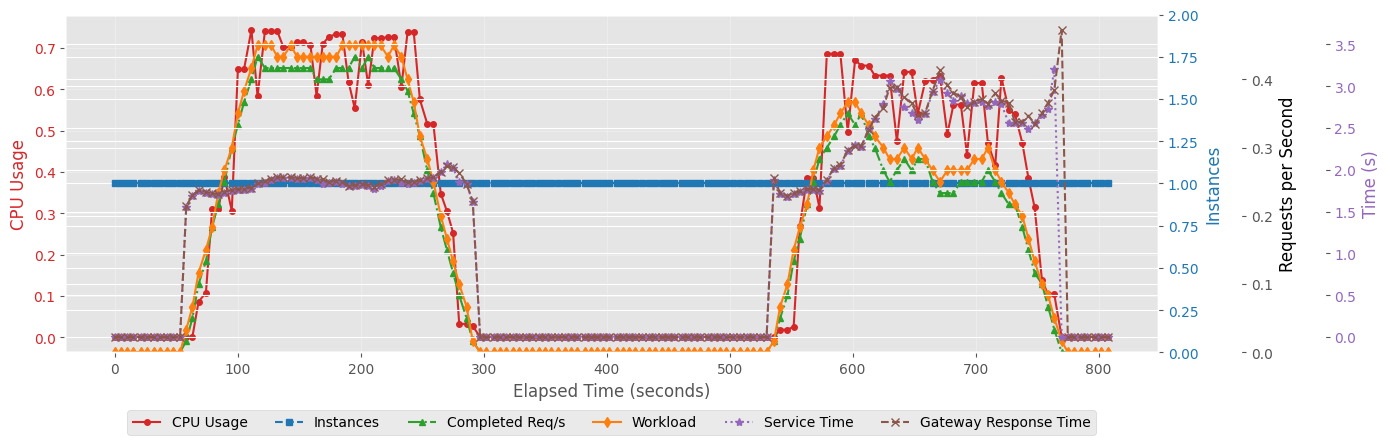

In [138]:
file_path = 'flask-app-1_instance_history-05.json'
plot_metrics(file_path)

Analyzing data for: flask-app-2
Loaded 150 data points


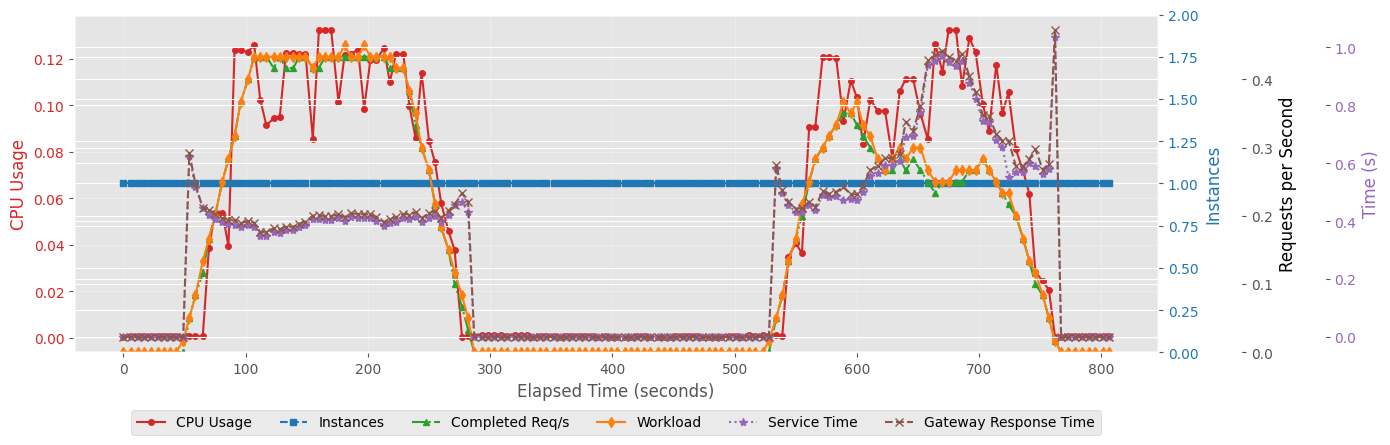

In [139]:
file_path = 'flask-app-2_instance_history-05.json'
plot_metrics(file_path)

Analyzing data for: flask-app-2
Loaded 67 data points


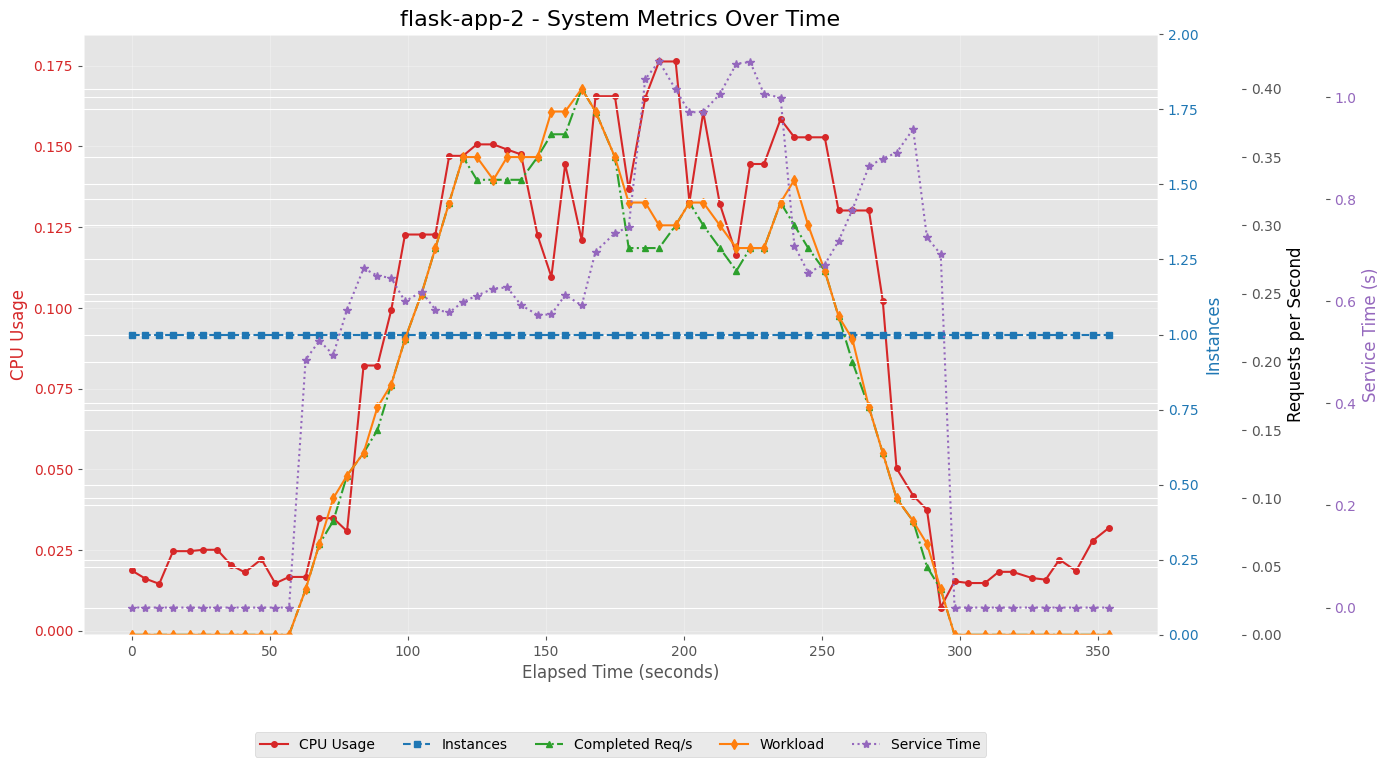

In [41]:
file_path = 'flask-app-2_instance_history.json'
plot_metrics(file_path)

Analyzing data for: flask-app-1
Loaded 78 data points


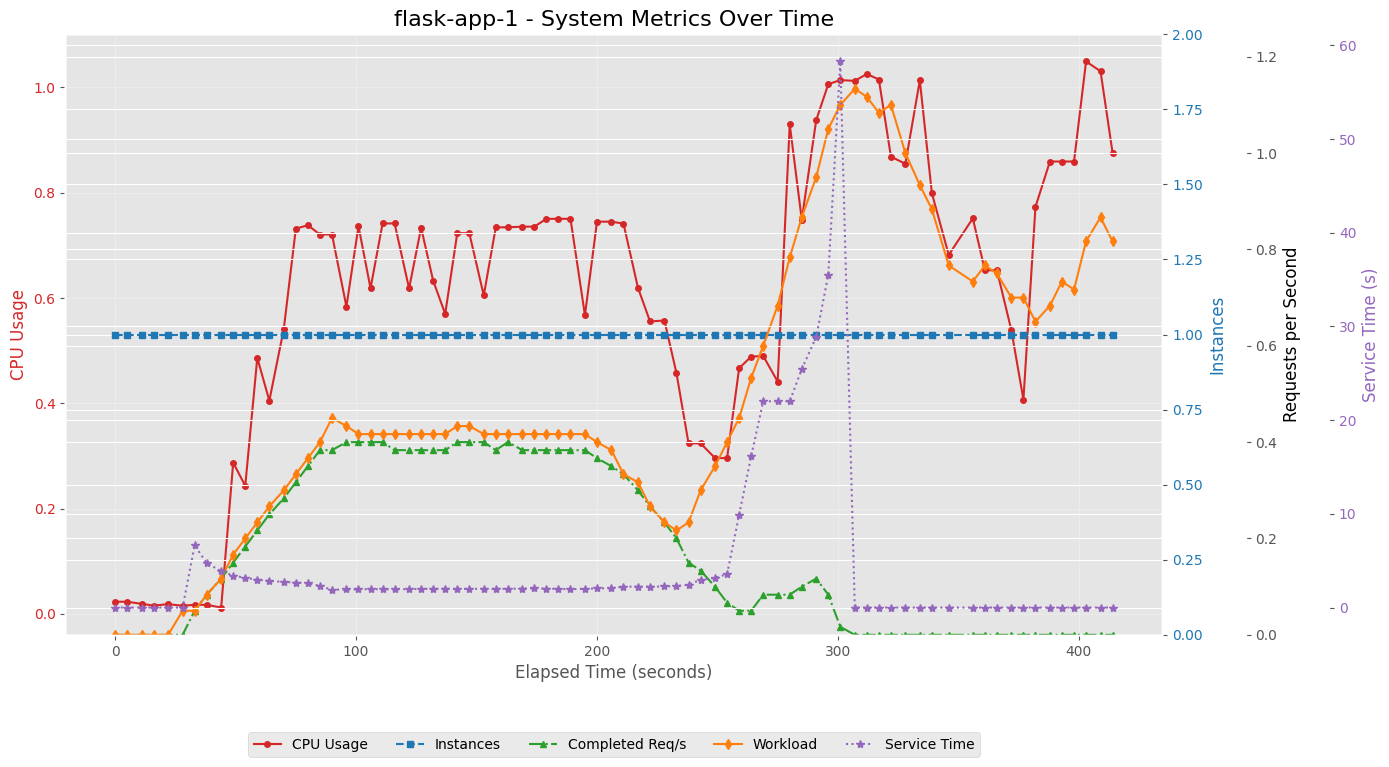

In [42]:
file_path = 'flask-app-1_instance_history-overload.json'
plot_metrics(file_path)

Analyzing data for: flask-app-2
Loaded 77 data points


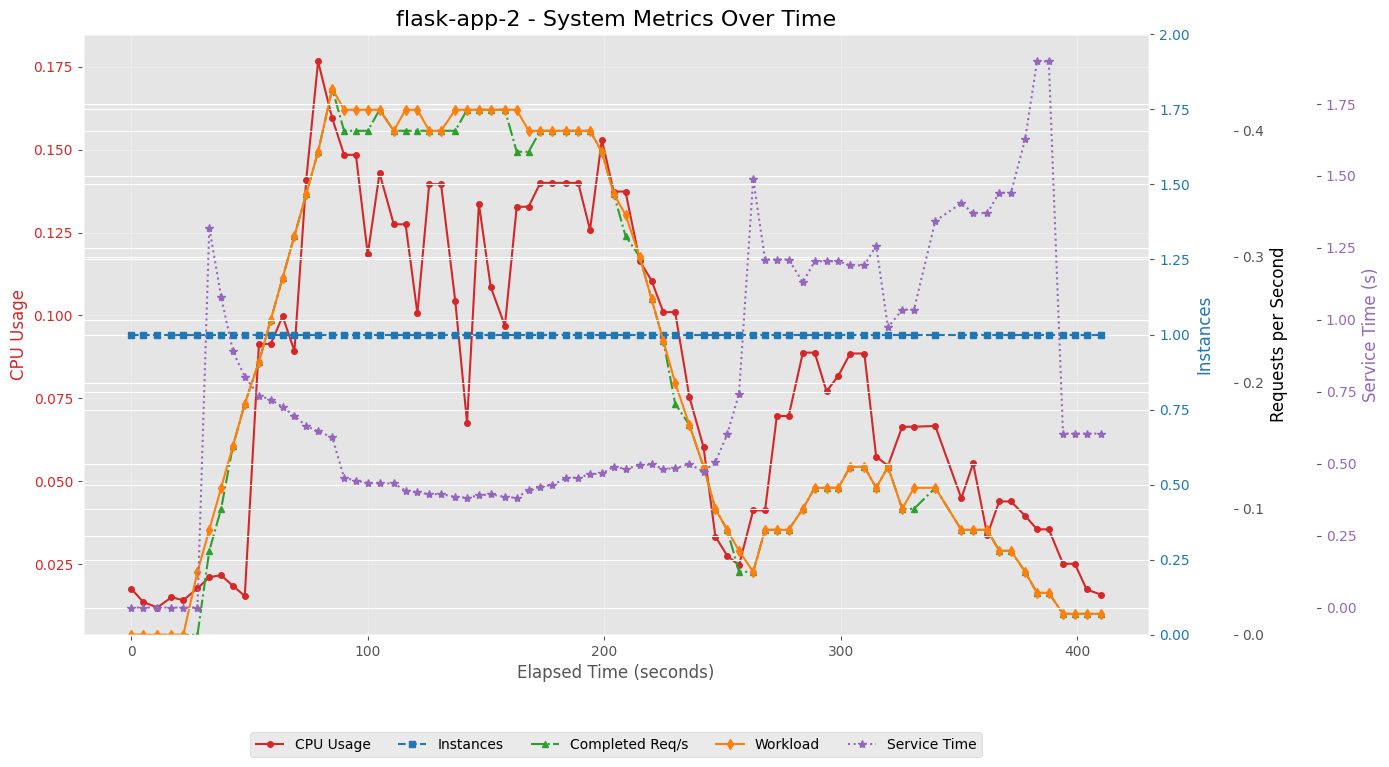

In [43]:
file_path = 'flask-app-2_instance_history-overload.json'
plot_metrics(file_path)

Analyzing data for: flask-app-1
Loaded 108 data points


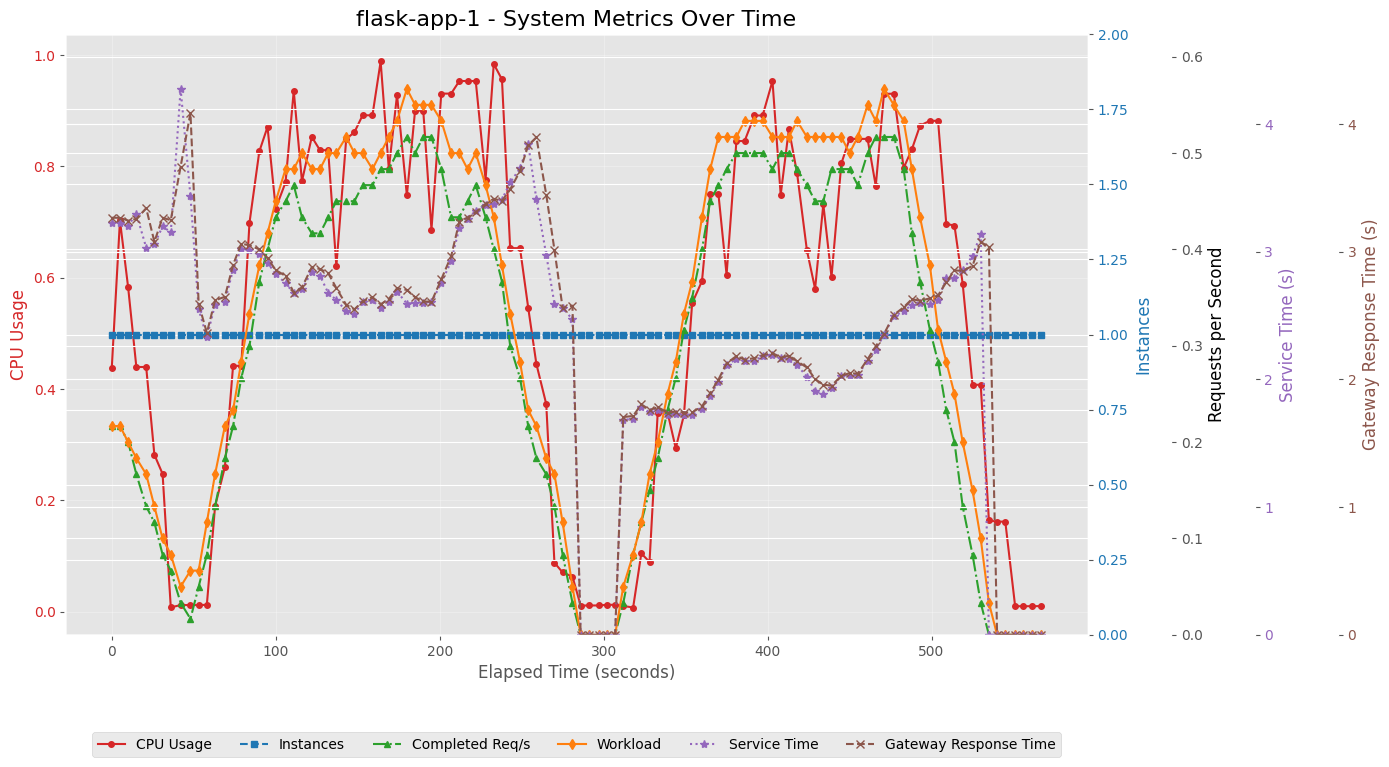

In [5]:
file_path = 'flask-app-1_instance_history.json'
plot_metrics(file_path)

Analyzing data for: flask-app-1
Loaded 62 data points


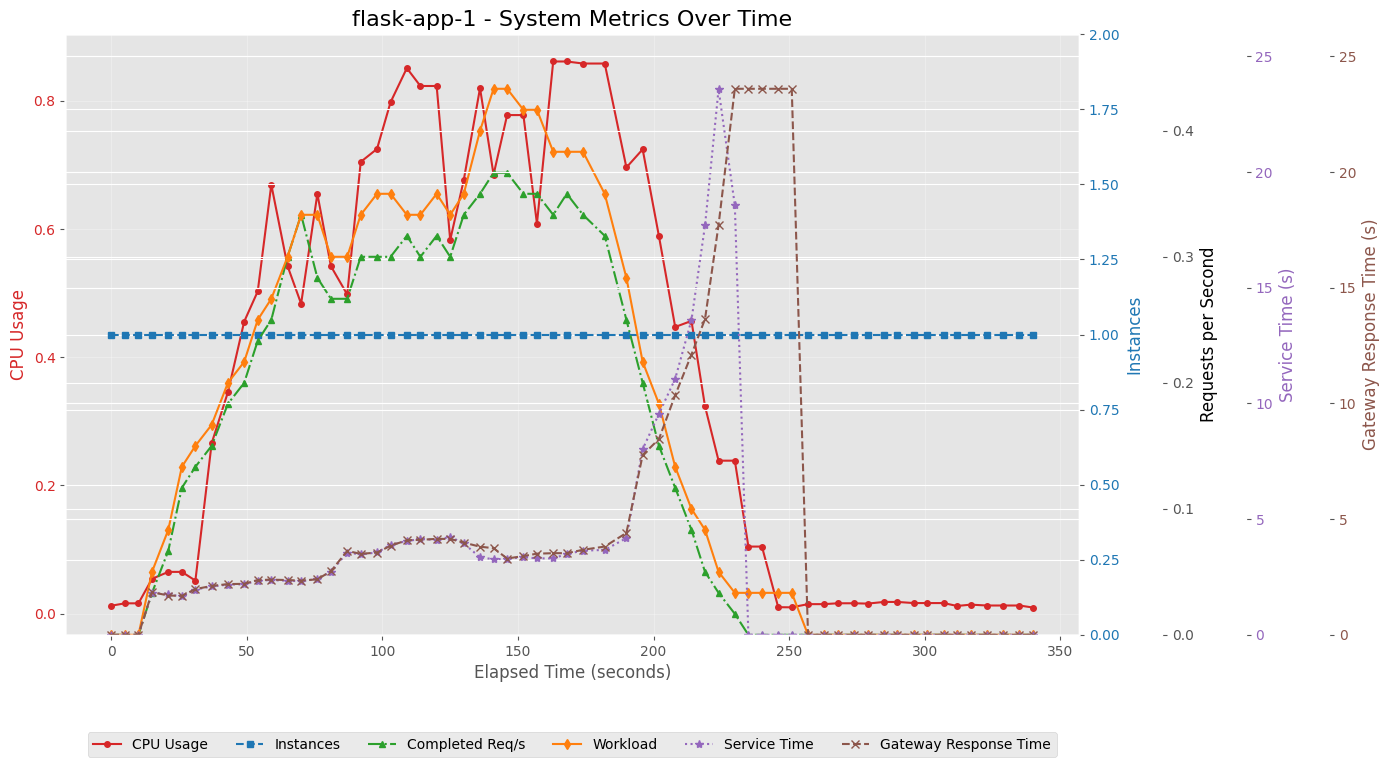

In [35]:
file_path = 'flask-app-1_instance_history.json'
plot_metrics(file_path)

# JMeter Data Visualization

This section visualizes the JMeter test results data independently, showing response times, request distribution over time, and performance patterns.

In [132]:
def visualize_jmeter_data(csv_path='jmeter.csv'):
    """Create comprehensive visualizations of JMeter test results"""
    try:
        # Load JMeter data
        jmeter_df = pd.read_csv(csv_path)
        print(f"Loaded {len(jmeter_df)} JMeter records")
        
        # Convert timestamp and calculate elapsed time
        jmeter_df['timestamp_dt'] = pd.to_datetime(jmeter_df['timeStamp'], unit='ms')
        start_time = jmeter_df['timestamp_dt'].min()
        jmeter_df['elapsed_seconds'] = (jmeter_df['timestamp_dt'] - start_time).dt.total_seconds()
        jmeter_df['response_time_seconds'] = jmeter_df['elapsed'] / 1000
        
        # Create single plot
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        fig.suptitle('JMeter Test Results Analysis', fontsize=16)
        
        # Response Time Over Time
        ax.scatter(jmeter_df['elapsed_seconds'], jmeter_df['response_time_seconds'], 
                   alpha=0.6, s=20, color='tab:blue')
        ax.set_xlabel('Elapsed Time (seconds)')
        ax.set_ylabel('Time (seconds)')
        ax.grid(True, alpha=0.3)
        
        # Add rolling average using numeric window
        jmeter_sorted = jmeter_df.sort_values('elapsed_seconds')
        
        # Calculate window size for approximately 60 seconds
        time_span = jmeter_sorted['elapsed_seconds'].max() - jmeter_sorted['elapsed_seconds'].min()
        total_requests = len(jmeter_sorted)
        avg_requests_per_sec = total_requests / time_span if time_span > 0 else 1
        window_size = max(1, int(60 * avg_requests_per_sec))
        
        rolling_avg = jmeter_sorted['response_time_seconds'].rolling(
            window=window_size, min_periods=1, center=False
        ).mean()
        
        ax.plot(jmeter_sorted['elapsed_seconds'], rolling_avg.values, color='red', linewidth=2, 
                label=f'~60s Rolling Average (window={window_size})')
        ax.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print("\n=== JMeter Test Summary ===")
        print(f"Total Requests: {len(jmeter_df)}")
        print(f"Test Duration: {jmeter_df['elapsed_seconds'].max():.1f} seconds")
        
        if 'success' in jmeter_df.columns:
            success_rate = (jmeter_df['success'] == True).mean() * 100
            print(f"Success Rate: {success_rate:.1f}%")
        else:
            print("Success Rate: N/A (no success column)")
            
        mean_response = jmeter_df['response_time_seconds'].mean()
        median_response = jmeter_df['response_time_seconds'].median()
        p95_response = jmeter_df['response_time_seconds'].quantile(0.95)
        print(f"Average Response Time: {mean_response:.3f} seconds")
        print(f"Median Response Time: {median_response:.3f} seconds")
        print(f"95th Percentile: {p95_response:.3f} seconds")
        print(f"Min Response Time: {jmeter_df['response_time_seconds'].min():.3f} seconds")
        print(f"Max Response Time: {jmeter_df['response_time_seconds'].max():.3f} seconds")
        print(f"Average Request Rate: {len(jmeter_df) / jmeter_df['elapsed_seconds'].max():.2f} req/s")
        
        # Thread-specific statistics
        if 'threadName' in jmeter_df.columns:
            print(f"\n=== Thread Performance ===")
            thread_stats = jmeter_df.groupby('threadName')['response_time_seconds'].agg(['mean', 'std', 'count'])
            for thread_name, stats in thread_stats.iterrows():
                print(f"{thread_name}: {stats['mean']:.3f}s ± {stats['std']:.3f}s (n={stats['count']})")
        else:
            print("\n=== Thread Performance ===")
            print("No thread information available in data")
            
    except FileNotFoundError:
        print(f"Error: JMeter CSV file '{csv_path}' not found")
        print("Make sure the file exists in the current directory")
        print("Current working directory files:")
        import os
        files = [f for f in os.listdir('.') if f.endswith('.csv')]
        print(f"CSV files found: {files}")
    except Exception as e:
        print(f"Error loading JMeter data: {e}")
        import traceback
        traceback.print_exc()

# Visualize the JMeter data
visualize_jmeter_data('jmeter.csv')


Error: JMeter CSV file 'jmeter.csv' not found
Make sure the file exists in the current directory
Current working directory files:
CSV files found: []
